# fifa analysis: skill prediction
---

## summary
* My goal is to predict the overall skill of players.
* I build a linear model that uses the highest correlated attributes.

## context
This is an exercise I have created to practice analytics. I am using a dataset from kaggle.com that represents individual fifa players. My goal is to provide insights for a team manager from the data. I assume that the team manager wants to optimize for the most skilled team that brings the most money.
   
## data
* Player personal attributes (Nationality, Club, Photo, Age, Value etc.)
* Player performance attributes (Overall, Potential, Aggression, Agility etc.)
* Player preferred position and ratings at all positions.

## key features
* Overall: overall rating of a player, on a scale from 1 to 100.
* Potential: the highest overall rating a player could progress to.
* Value: current market value of a player, annually
* Wage: the weekly wage of a player
---


---
# EDA: correlations

## problem
Which attributes are most highly correlated with overall skill? Secondarily, are these the same skills that are correlated with age?

## hypothesis
The attributes most highly correlated with overall skill are global attributes such as speed. Secondarily, these attributes are also correlated with age.

## assumptions
* Correlations are done irrespective of position. 
* It is possible to calculate the overall skill of a player by looking at his individual attributes, rather than simply using the overall value offered by the dataset.
* Understanding the connection between age and attributes allows us to predict performance by anticipating whether a player will improve as he grows older.

## procedure
* imports
* validate that the distributions of the data are normal
* find attributes that are most highly correlated with overall

### imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
players = pd.read_csv('../data/full_filter_age_adjusted.csv',index_col='index')
players.shape

/Users/nico/code/pydata-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(17929, 79)

### validate normal distribution

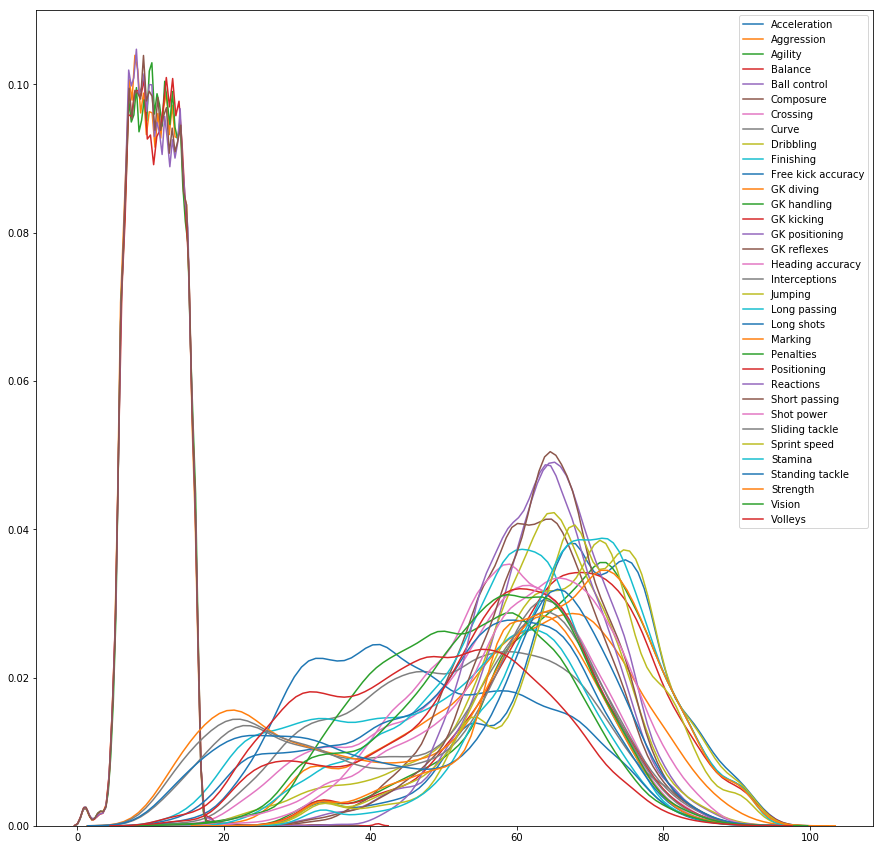

In [29]:


#remove the pluses and minuses from these numbers
import re

skill_columns = ['Acceleration',
       'Aggression', 'Agility', 'Balance', 'Ball control', 'Composure',
       'Crossing', 'Curve', 'Dribbling', 'Finishing', 'Free kick accuracy',
       'GK diving', 'GK handling', 'GK kicking', 'GK positioning',
       'GK reflexes', 'Heading accuracy', 'Interceptions', 'Jumping',
       'Long passing', 'Long shots', 'Marking', 'Penalties', 'Positioning',
       'Reactions', 'Short passing', 'Shot power', 'Sliding tackle',
       'Sprint speed', 'Stamina', 'Standing tackle', 'Strength', 'Vision',
       'Volleys']

def stripValue(value):
    if isinstance(value, str):
        return int(re.findall('\d+',value)[0])
    else:
        return None
    
# remove missing data
players.dropna(inplace=True)

for column in skill_columns:
    players[column] = players[column].apply(stripValue)
    
# remove missing data
players.dropna(inplace=True)

# create plotting objects
fig, ax = plt.subplots(figsize=(15,15))

for column in skill_columns:
    
    sns.distplot(
        players[column],
        bins=50, 
        axlabel=False,
        hist=False,
        kde_kws={"label": column},
        ax=ax,
    )
    
# these distributions are reasonable.
# most of them are skewed left, centered around 60
# many of them have a cluster of low skill

### heat map

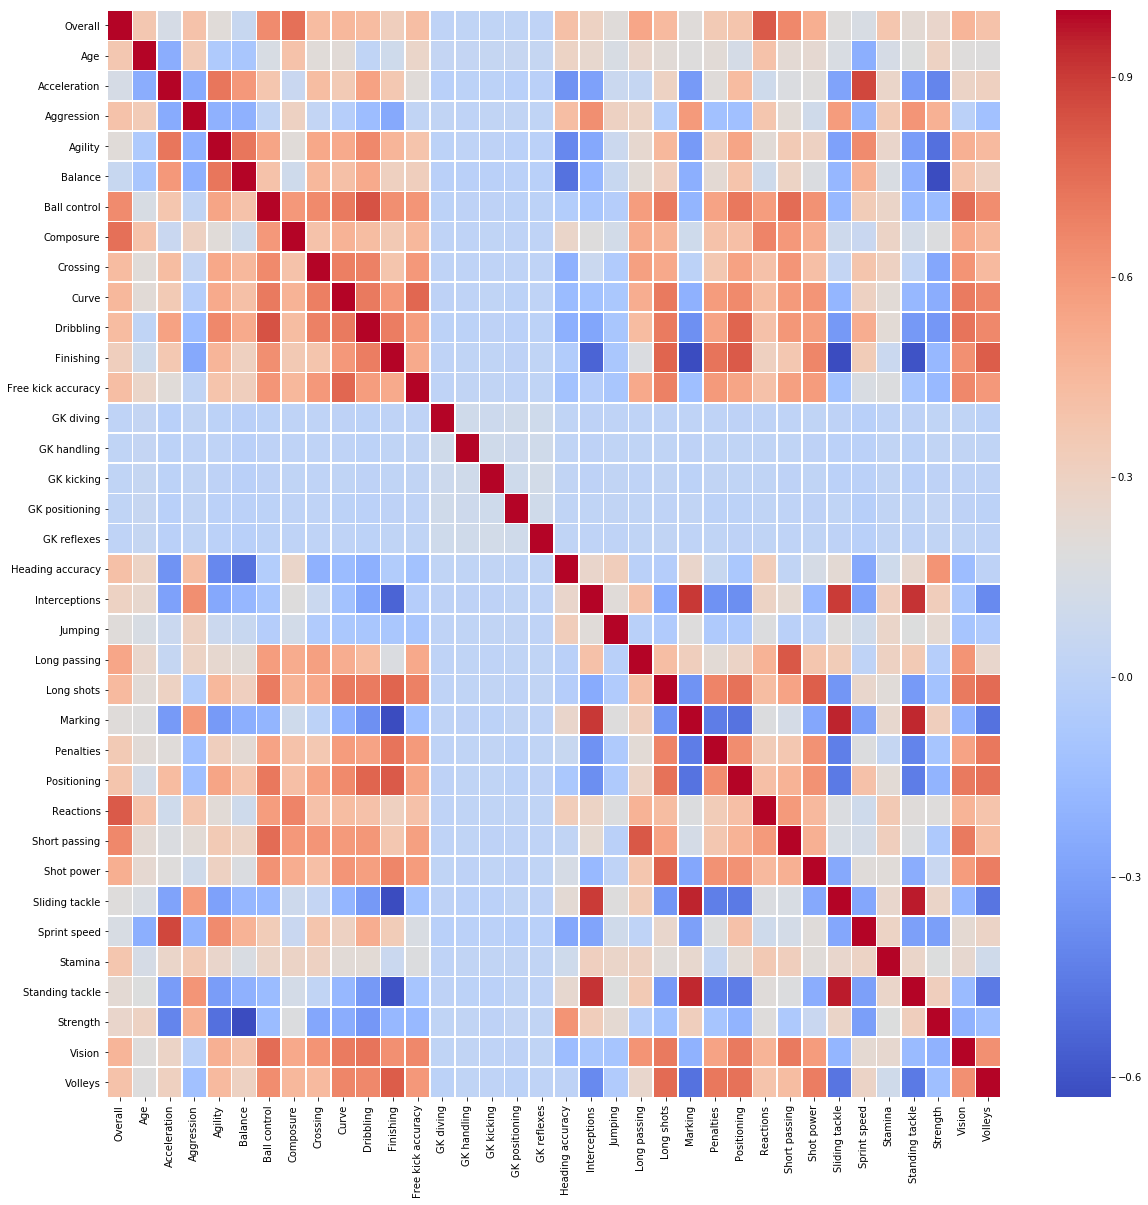

In [47]:
# explore correlations across all skills
correlations = players[['Overall','Age'] + skill_columns].corr()

fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(correlations,annot=False,cmap='coolwarm', linewidths=.5, ax=ax)

### correlation matrix

In [48]:
# explore correlations to overall and age
correlations = correlations.loc[skill_columns,['Overall','Age']]
correlations.sort_values('Overall',ascending=False)



,Overall,Age
Reactions,0.812815,0.400907
Composure,0.741791,0.399905
Short passing,0.660311,0.225363
Ball control,0.645842,0.152467
Long passing,0.537197,0.255433
Shot power,0.502117,0.239033
Vision,0.466864,0.191703
Curve,0.456252,0.211423
Long shots,0.443460,0.210411
Dribbling,0.437398,0.018856


---
# linear model comparisons

## problem
How well can the top correlated attribute predict overall skill, compared to a model that uses the top 2 attributes as predictors, and to a model that uses the top 3 attributes?

## hypothesis
Because the correlation between reactions and overall is so high, the single predictor model will perform almost as well as the other 2. 

## assumptions

## procedure


### Linear Regression: 2 factors


In [50]:
#define the training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = players['Overall']
X = players[['Reactions','Composure']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coefficients = pd.DataFrame(lm.coef_,X.columns)
coefficients.columns = ['Coefficient']
coefficients

/Users/nico/code/pydata-env/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


,Coefficient
Reactions,0.413831
Composure,0.220518


Text(0,0.5,'Predicted Y')

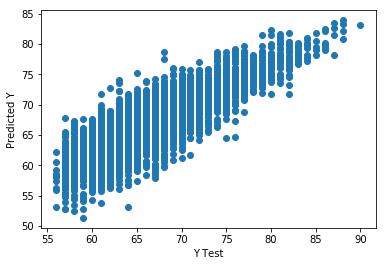

In [51]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

### evaluate


In [52]:
# evaluate  model performance by calculating the residual sum of squares 
# and the explained variance score (R^2).
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

# these values will be more relevant when comparing this model 
# performance to subsequent models

MAE: 2.43849035354
MSE: 9.3825332986
RMSE: 3.06309211396


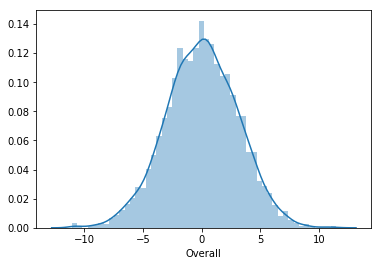

In [53]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

### first conclusion
Looking at the coefficients calculated by the model, we see that reactions have twice as much influence as composure. Perhaps we don't gain much in our predictive power by including composure. To evaluate this, build another model using only reactions as your predictor.

Pragmatically, this is not a good model though. Reactions are not nearly as easy to quantify as other metrics, so it is dubious to recommend to a coach to evaluate up-and-coming players based on their reactions.

#### further study
* build another model using only reactions as predictor. Compare this to the model that uses both reactions and composure. how much more predictive power is gained by including composure?
* Build another model that is more pragmatic. Exclude reactions, instead use more measurable metrics.

## Simple Linear Regression: low correlation features
in this model, I am only going to use features with low correlation to see how good of a predictor I can create.

In [ ]:
#skills with the highest correlation
correlation_overall = correlation_matrix['Overall'].sort_values(ascending=False)

#exclude features with the highest correlations,those above 0.53
low_correlated_skills  = correlation_overall[correlation_overall < 0.53].index.values
low_correlated_skills

In [ ]:
#define the training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = player_stats['Overall']
X = player_stats[low_correlated_skills]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients

In [ ]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

evaluate  model performance by calculating the residual sum of squares and the explained variance score (R^2).

In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

# second conclusion
in this second model I excluded the most highly correlated features,those being reactions and composure.
I wanted to see if I could create a predictive model using very lowly correlated features.my assumption was that the higher the correlation,the more likely that feature predicts the y value.perhaps this is true,and there is another truth in here.the other truth is that a large group of lowly correlated features can also give a good predictive model.

now my goal is to create the most predictive model.I will do this by including the highly correlated features as well as the lowly correlated features into my model.

## Simple Linear Regression: all features


In [ ]:
#define the training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = player_stats['Overall']
X = player_stats[skill_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

lm = LinearRegression()
lm.fit(X_train,y_train)

coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coefficient']
coeffecients.sort_values(by='Coefficient',ascending=False)

even though composure is more highly correlated then ball control, here ball control has a higher coefficient then  composure. I must have a wrong assumption about how this math works. something I can try to do is to see the correlation between coefficients and correlation values.

In [ ]:
#compare predicted to actual values
predictions = lm.predict(X_test)

plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

## Evaluating the Model

evaluate  model performance by calculating the residual sum of squares and the explained variance score (R^2).

In [ ]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [ ]:
#make sure residuals are normally distributed and not too big
sns.distplot((y_test-predictions),bins=50);

## third conclusion
it appears that the best model is when you use the most features.

* highly correlated features RMSE: 3.31230582722
* only low correlated future RMSE: 3.25479269275
* all features RMSE: 2.62305737694